# Movie Recommender System   
**CS 695 - Machine Learning**  
Khalid Isahak  
Jay Patel  
Kishan Shah


## Exploratory Data Analysis  
First, we will import the data and display the first few rows

In [ ]:
import pandas as pd

# Load the data
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

# Display the first few rows of the datasets
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1.112486e+09
1,1,29,3.5,1.112485e+09
2,1,32,3.5,1.112485e+09
3,1,47,3.5,1.112485e+09
4,1,50,3.5,1.112485e+09


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Sample 20% of the ratings data
ratings = ratings.sample(frac=0.5, random_state=42)

# Get the movie IDs from the sampled ratings
sampled_movie_ids = ratings['movieId'].unique()

# Filter the movies DataFrame to include only the movies in the sampled ratings
movies = movies[movies['movieId'].isin(sampled_movie_ids)]

# Verify the sizes of the sampled DataFrames
print(f"Sampled Ratings Shape: {ratings.shape}")
print(f"Sampled Movies Shape: {movies.shape}")

Sampled Ratings Shape: (1436931, 4)
Sampled Movies Shape: (15969, 3)


### Basic Statistics

In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,25806.000000,25806.000000,25806.000000,2.580600e+04
mean,454.810974,9116.440208,3.496396,1.097577e+09
std,246.880978,19971.785777,1.087005,1.607641e+08
min,1.000000,1.000000,0.500000,8.275006e+08
25%,251.000000,908.000000,3.000000,9.657100e+08
50%,451.000000,2206.000000,3.500000,1.101143e+09
75%,672.000000,4855.000000,4.000000,1.208213e+09
max,876.000000,128594.000000,5.000000,1.427670e+09


Rating Distribution

<ipython-input-6-95649cbb94af>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


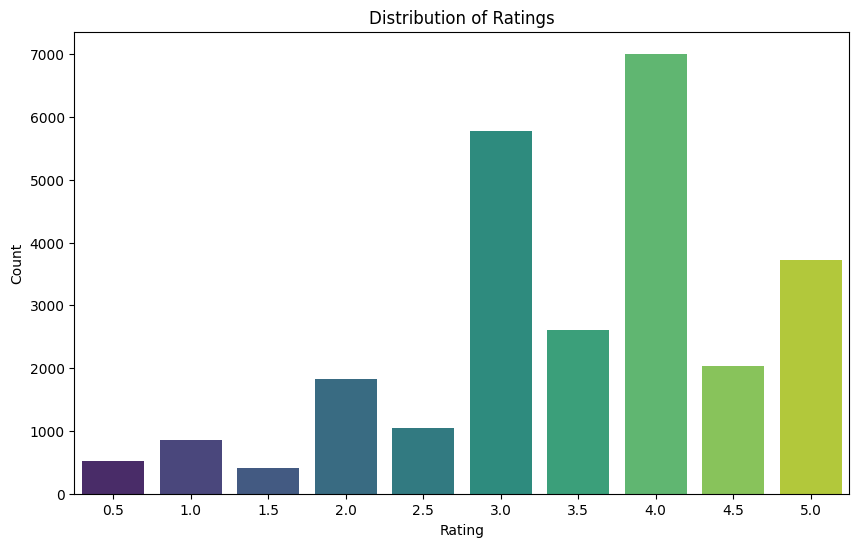

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# Number of unique users and movies
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

print(f'Number of users: {num_users}')
print(f'Number of movies: {num_movies}')

# Check for missing values
print(ratings.isnull().sum(), movies.isnull().sum())

Number of users: 875
Number of movies: 5366
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 movieId    0
title      0
genres     0
dtype: int64


### Leave One Out Split  
Unlike a normal split, utilizing a leave one out approach where we can split one of each user's ratings to the test set. This rating can later be used for evaluation purposes.

In [ ]:
import numpy as np

# Leave-one-out: For each user, move one rating to the test set.
def leave_one_out_split(ratings):
    test_data = ratings.groupby('userId').apply(lambda x: x.sample(1)).reset_index(drop=True)
    train_data = ratings[~ratings.index.isin(test_data.index)]
    return train_data, test_data

train_data, test_data = leave_one_out_split(ratings)

## Collaborative Filtering - Jay Patel


Collaborative filtering is a technique used to make automatic predictions (filtering) about the interests of similar users, hence the word "collaborative." For this model, we will be utilizing the rating that similar users have to recommend additional movies for the initial user.


### Calculate Cosine Similarity with Dense Matrix

We use cosine similarity to calculate the similarity between users. Cosine similarity measures the cosine of the angle between two vectors, giving us a value between -1 and 1.   

### Creating the User - Item Matrix

We transform the ratings data into a user-item matrix, where rows represent users, columns represent movies, and the values are the ratings given by users to movies.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Create the user-item matrix for the training data
train_user_item_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Compute the cosine similarity matrix based on the training data
user_similarity = cosine_similarity(train_user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=train_user_item_matrix.index, columns=train_user_item_matrix.index)

<ipython-input-4-81c336f4ccec>:4: PerformanceWarning: The following operation may generate 3678407880 cells in the resulting pandas object.
  train_user_item_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)


### Predict Ratings with Dense Matrix

We predict the ratings for movies not rated by users using the similarity matrix and centered ratings. This helps us generate personalized recommendations for each user.

In [ ]:
# Function to predict ratings with regularization
def predict_ratings_with_regularization(user_item_matrix, user_similarity, reg_param=0.1):
    mean_user_rating = user_item_matrix.mean(axis=1).reshape(-1, 1)
    ratings_diff = user_item_matrix - mean_user_rating

    # Apply regularization
    pred = mean_user_rating + user_similarity.dot(ratings_diff) / (np.abs(user_similarity).sum(axis=1).reshape(-1, 1) + reg_param)

    return pred

# Predict ratings using the training data's user-item matrix and similarity matrix with regularization
predicted_ratings = predict_ratings_with_regularization(train_user_item_matrix.values, user_similarity, reg_param=0.1)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=train_user_item_matrix.index, columns=train_user_item_matrix.columns)

In [ ]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(test_data, predicted_ratings_df):
    test_user_item_matrix = test_data.pivot(index='userId', columns='movieId', values='rating')
    predicted = []
    actual = []

    for row in test_data.itertuples():
        user_id = row.userId
        movie_id = row.movieId
        actual_rating = row.rating

        if user_id in predicted_ratings_df.index and movie_id in predicted_ratings_df.columns:
            predicted_rating = predicted_ratings_df.loc[user_id, movie_id]
            predicted.append(predicted_rating)
            actual.append(actual_rating)

    predicted = np.array(predicted)
    actual = np.array(actual)

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return rmse

# Calculate RMSE
rmse = calculate_rmse(test_data, predicted_ratings_df)
print(f"Test RMSE: {rmse}")

Test RMSE: 3.0506743395327223


### Generate Recommendations

Finally, We generate movie recommendations for a specific user based on the predicted ratings. The top recommended movies are retrieved from the `movies` DataFrame.

In [ ]:
def get_recommendations(user_id, num_recommendations=5):
    if user_id not in predicted_ratings_df.index:
        print(f"User ID {user_id} not found in the prediction data. Available user IDs are: {predicted_ratings_df.index.tolist()[:10]}")
        return pd.DataFrame()  # Return an empty DataFrame or handle as you see fit

    user_predicted_ratings = predicted_ratings_df.loc[user_id].sort_values(ascending=False)
    recommended_movie_ids = user_predicted_ratings.index[:num_recommendations].tolist()
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
    return recommended_movies

# Get recommendations for a user
user_id = 8
recommendations = get_recommendations(user_id)
print(recommendations)

     movieId                              title                       genres
293      296                Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller
315      318   Shawshank Redemption, The (1994)                  Crime|Drama
352      356                Forrest Gump (1994)     Comedy|Drama|Romance|War
583      589  Terminator 2: Judgment Day (1991)                Action|Sci-Fi
587      593   Silence of the Lambs, The (1991)        Crime|Horror|Thriller


These recommendations are based on the user’s predicted ratings, suggesting movies that align with their preferences and past ratings. The genres provide additional context, showing a mix of Action, Sci-Fi, Crime, Drama, Horror, Comedy, and Thriller, reflecting the diverse tastes of the user.

## Content Filtering - Kishan Shah

In [ ]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres_str'] = movies['genres'].apply(lambda x: ' '.join(x))

movies.head()

,movieId,title,genres,genres_str
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",Adventure Children Fantasy
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",Comedy Romance
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",Comedy Drama Romance
4,5,Father of the Bride Part II (1995),[Comedy],Comedy


In [ ]:
# Create the user-item matrix from the training data
train_user_item_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error

# Filter movies to only include those present in the training data
train_movie_ids = train_user_item_matrix.columns
filtered_movies = movies[movies['movieId'].isin(train_movie_ids)]

# Vectorize the genres for the filtered movies
count_vectorizer = CountVectorizer()
genre_matrix = count_vectorizer.fit_transform(filtered_movies['genres_str'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(genre_matrix)

# Verify the shape of the cosine similarity matrix
print(cosine_sim.shape)

(15965, 15965)


In [ ]:
def predict_ratings_content_with_regularization(user_item_matrix, cosine_sim, reg_param=0.1):
    mean_user_rating = user_item_matrix.mean(axis=1).reshape(-1, 1)
    ratings_diff = user_item_matrix - mean_user_rating

    # Apply regularization
    pred = mean_user_rating + cosine_sim.dot(ratings_diff.T).T / (np.abs(cosine_sim).sum(axis=1) + reg_param)

    return pred

# Predict ratings using the training data's user-item matrix and content similarity matrix with regularization
predicted_ratings = predict_ratings_content_with_regularization(train_user_item_matrix.values, cosine_sim, reg_param=0.1)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=train_user_item_matrix.index, columns=train_user_item_matrix.columns)

In [ ]:
from sklearn.metrics import mean_squared_error

predicted_ratings = []
actual_ratings = []

for _, row in test_data.iterrows():
    user = row['userId']
    movie = row['movieId']
    actual_rating = row['rating']

    if user in train_user_item_matrix.index and movie in train_user_item_matrix.columns:
        predicted_rating = predicted_ratings_df.loc[user, movie]
        predicted_ratings.append(predicted_rating)
        actual_ratings.append(actual_rating)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f"Overall RMSE for Content-Based Filtering: {rmse}")

Overall RMSE for Content-Based Filtering: 3.753447776456357


In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim, movies=movies, n=10):
    idx = movies[movies['title'] == title].index[0]
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the n most similar movies
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]

    return movies['title'].iloc[movie_indices]

print(get_recommendations('Toy Story (1995)'))

2209                                           Antz (1998)
3027                                    Toy Story 2 (1999)
3663        Adventures of Rocky and Bullwinkle, The (2000)
3922                      Emperor's New Groove, The (2000)
4790                                 Monsters, Inc. (2001)
10114    DuckTales: The Movie - Treasure of the Lost La...
10987                                     Wild, The (2006)
11871                               Shrek the Third (2007)
13337                       Tale of Despereaux, The (2008)
18274    Asterix and the Vikings (Astérix et les Viking...
Name: title, dtype: object


## Matrix Factorization - Khalid Isahak

In [ ]:
import numpy as np
from scipy.sparse.linalg import svds

# Convert the user-item matrix to a NumPy array
user_item_matrix_np = user_item_matrix.to_numpy()

# Perform SVD
U, sigma, Vt = svds(user_item_matrix_np, k=75)

# Convert sigma to a diagonal matrix
sigma = np.diag(sigma)

# Reconstruct the user-item matrix
predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns)

In [ ]:
def predict_ratings(user_id, movie_id):
    user_idx = user_id - 1  # Adjusting for zero-based indexing
    movie_idx = movie_id - 1
    return predicted_ratings_df.iloc[user_idx, movie_idx]

# Example prediction
predicted_rating = predict_ratings(1, 2)
print(f"Predicted rating for user 1 and movie 2: {predicted_rating}")

Predicted rating for user 1 and movie 2: 1.5231899589143163


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
# Create mappings from userId and movieId to indices in the matrix
user_to_index = {user_id: i for i, user_id in enumerate(user_item_matrix.index)}
movie_to_index = {movie_id: i for i, movie_id in enumerate(user_item_matrix.columns)}
# Calculate RMSE on the test set
def calculate_rmse(predicted_ratings, actual_ratings):
    predicted = []
    actual = []
    for index, row in actual_ratings.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        # Use the mappings to get the correct indices
        if user_id in user_to_index and movie_id in movie_to_index:
            user_idx = user_to_index[user_id]
            movie_idx = movie_to_index[movie_id]

            predicted.append(predicted_ratings_df.iloc[user_idx, movie_idx])
            actual.append(row['rating'])

    predicted = np.array(predicted)
    actual = np.array(actual)
    return np.sqrt(mean_squared_error(actual, predicted))

# Calculate RMSE
rmse = calculate_rmse(predicted_ratings_df, test_data)
print(f"Test RMSE: {rmse}")

Test RMSE: 2.3016415173002938
